# Minplus algebra experiment

This code attempts to learn the 32D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 128     # number of hidden units
layers = 20      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1907.44873046875
iteration 0 loss 3.109944449908605e+18


iteration 5000 loss 3420649422848.0


iteration 10000 loss 228678254592.0


iteration 15000 loss 16779911168.0


iteration 20000 loss 1219161984.0


iteration 25000 loss 82892512.0


iteration 30000 loss 4255579.0


iteration 35000 loss 48703.46875


iteration 40000 loss 606.2569580078125


iteration 45000 loss 33.47629165649414


iteration 50000 loss 5.289477825164795


iteration 55000 loss 1.7761770486831665


iteration 60000 loss 1.876196026802063


iteration 65000 loss 1.535191297531128


iteration 70000 loss 1.2819331884384155


iteration 75000 loss 0.9411439895629883


iteration 80000 loss 0.7000770568847656


iteration 85000 loss 0.5657321810722351


iteration 90000 loss 0.42049452662467957


iteration 95000 loss 0.3345387578010559


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.25354427099227905


iteration 105000 loss 0.21953749656677246


iteration 110000 loss 0.1847420036792755


iteration 115000 loss 0.16342951357364655


iteration 120000 loss 0.14488644897937775


iteration 125000 loss 0.1297878623008728


iteration 130000 loss 0.1172611266374588


iteration 135000 loss 0.10778255015611649


iteration 140000 loss 0.09987584501504898


iteration 145000 loss 0.0920332595705986


iteration 150000 loss 0.08517319709062576


iteration 155000 loss 0.0797029361128807


iteration 160000 loss 0.07458750158548355


iteration 165000 loss 0.06969180703163147


iteration 170000 loss 0.06630789488554001


iteration 175000 loss 0.06287671625614166


iteration 180000 loss 0.05998685583472252


iteration 185000 loss 0.056438859552145004


iteration 190000 loss 0.053777243942022324


iteration 195000 loss 0.05107234790921211


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.04841073974967003


iteration 205000 loss 0.04766528680920601


iteration 210000 loss 0.04554921016097069


iteration 215000 loss 0.04389851912856102


iteration 220000 loss 0.04207170754671097


iteration 225000 loss 0.04048014059662819


iteration 230000 loss 0.038965146988630295


iteration 235000 loss 0.037571292370557785


iteration 240000 loss 0.036258019506931305


iteration 245000 loss 0.034876976162195206


iteration 250000 loss 0.03374530002474785


iteration 255000 loss 0.032555434852838516


iteration 260000 loss 0.031444139778614044


iteration 265000 loss 0.03035382367670536


iteration 270000 loss 0.029312288388609886


iteration 275000 loss 0.028229808434844017


iteration 280000 loss 0.02737920545041561


iteration 285000 loss 0.026557372882962227


iteration 290000 loss 0.025682583451271057


iteration 295000 loss 0.02497253008186817


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.024226080626249313


iteration 305000 loss 0.02408389188349247


iteration 310000 loss 0.023711709305644035


iteration 315000 loss 0.023366248235106468


iteration 320000 loss 0.02303905412554741


iteration 325000 loss 0.022721223533153534


iteration 330000 loss 0.022411083802580833


iteration 335000 loss 0.02210913971066475


iteration 340000 loss 0.021815409883856773


iteration 345000 loss 0.02152767963707447


iteration 350000 loss 0.02123991958796978


iteration 355000 loss 0.02096300758421421


iteration 360000 loss 0.0206866804510355


iteration 365000 loss 0.020420491695404053


iteration 370000 loss 0.020159563049674034


iteration 375000 loss 0.019895171746611595


iteration 380000 loss 0.019644003361463547


iteration 385000 loss 0.019382335245609283


iteration 390000 loss 0.019142499193549156


iteration 395000 loss 0.018906548619270325


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.018672524020075798


iteration 405000 loss 0.018644016236066818


iteration 410000 loss 0.01860876753926277


iteration 415000 loss 0.018575191497802734


iteration 420000 loss 0.018543081358075142


iteration 425000 loss 0.018511880189180374


iteration 430000 loss 0.018481269478797913


iteration 435000 loss 0.018451165407896042


iteration 440000 loss 0.0184215996414423


iteration 445000 loss 0.018392421305179596


iteration 450000 loss 0.0183637086302042


iteration 455000 loss 0.01833530142903328


iteration 460000 loss 0.018307168036699295


iteration 465000 loss 0.018279142677783966


iteration 470000 loss 0.01825065352022648


iteration 475000 loss 0.018222752958536148


iteration 480000 loss 0.018195217475295067


iteration 485000 loss 0.01816830039024353


iteration 490000 loss 0.018141545355319977


iteration 495000 loss 0.01811501383781433


L2 loss -- Plot

loss -947.0491943359375


loss -1346.3538818359375


loss -1440.33984375


loss -1484.225341796875


loss -1510.7532958984375


loss -1526.219482421875


loss -1533.5599365234375


loss -1538.1387939453125


loss -1541.2139892578125


loss -1542.9200439453125


loss -1543.87890625


loss -1544.4227294921875


loss -1544.748291015625


loss -1544.9537353515625


loss -1545.0625


loss -1545.09033203125


loss -1545.0966796875


loss -1545.09765625


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


loss -1545.09814453125


final mse:  1.7985404383580317e-06
max, min: 2.8233907 -4.6114945
loss -947.0491943359375


loss -1328.509765625


loss -1438.7467041015625


loss -1502.2333984375


loss -1544.173095703125


loss -1571.4794921875


loss -1588.9482421875


loss -1599.6336669921875


loss -1605.6181640625


loss -1608.846923828125


loss -1610.4296875


loss -1611.393310546875


loss -1612.12744140625


loss -1612.64501953125


loss -1612.8740234375


loss -1612.9371337890625


loss -1612.9503173828125


loss -1612.953125


loss -1612.9534912109375


loss -1612.9534912109375


loss -1612.9534912109375


loss -1612.9534912109375


loss -1612.95361328125


loss -1612.9534912109375


loss -1612.95361328125


loss -1612.9534912109375


loss -1612.9534912109375


loss -1612.95361328125


loss -1612.9534912109375


loss -1612.95361328125


loss -1612.95361328125


loss -1612.9534912109375


loss -1612.9534912109375


loss -1612.9534912109375


loss -1612.9534912109375


loss -1612.9534912109375


loss -1612.9534912109375


loss -1612.95361328125


loss -1612.9534912109375


loss -1612.95361328125


final mse:  1.817016709537711e-06
max, min: 4.923043 -4.224277


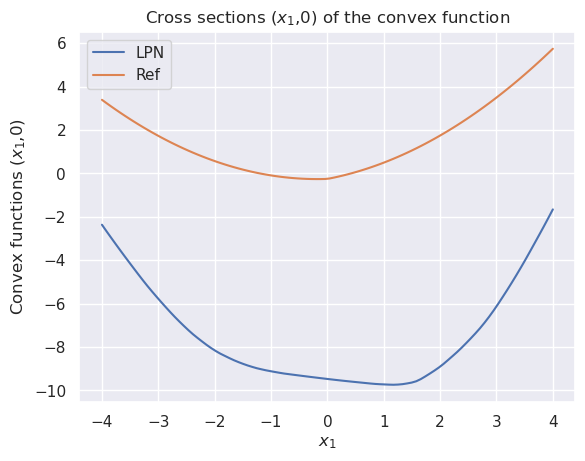

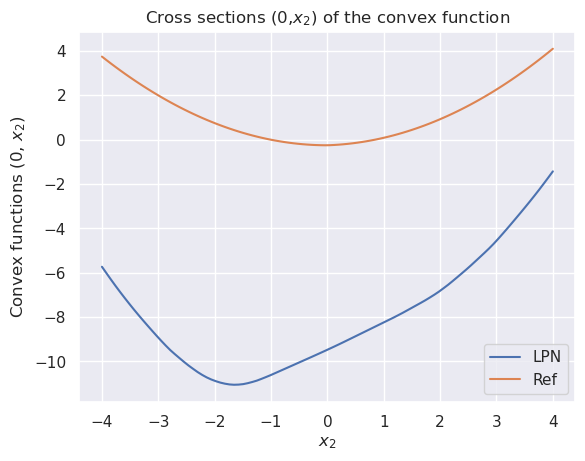

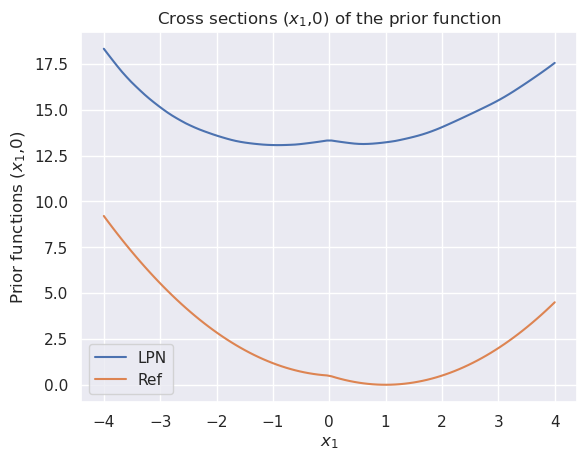

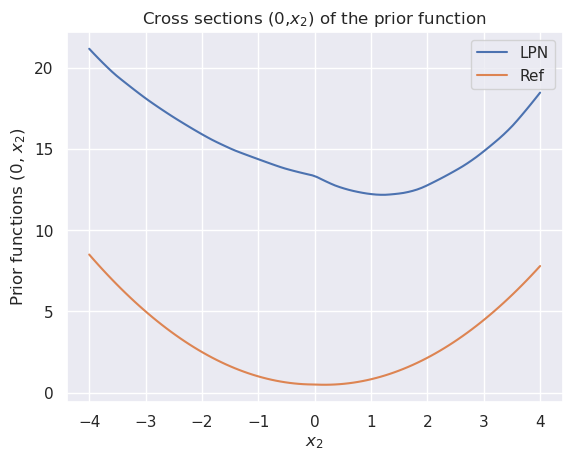

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 23493.45703125
iteration 0 loss 2.951177169881006e+18


iteration 5000 loss 84112614359040.0


iteration 10000 loss 5552815472640.0


iteration 15000 loss 410681016320.0


iteration 20000 loss 30563463168.0


iteration 25000 loss 2266092288.0


iteration 30000 loss 166166576.0


iteration 35000 loss 11696601.0


iteration 40000 loss 704795.375


iteration 45000 loss 30424.248046875


iteration 50000 loss 2827.03125


iteration 55000 loss 828.760498046875


iteration 60000 loss 33.008872985839844


iteration 65000 loss 8.803618431091309


iteration 70000 loss 4.534111022949219


iteration 75000 loss 3.163485527038574


iteration 80000 loss 2.4691638946533203


iteration 85000 loss 2.2643327713012695


iteration 90000 loss 47.48745346069336


iteration 95000 loss 1.692270040512085


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 1.546388864517212


iteration 105000 loss 1.4889130592346191


iteration 110000 loss 1.4050750732421875


iteration 115000 loss 1.335760474205017


iteration 120000 loss 1.2754114866256714


iteration 125000 loss 1.22267746925354


iteration 130000 loss 1.1751679182052612


iteration 135000 loss 1.1332066059112549


iteration 140000 loss 1.0953551530838013


iteration 145000 loss 1.3690452575683594


iteration 150000 loss 4.90513801574707


iteration 155000 loss 1.001853585243225


iteration 160000 loss 0.9759320020675659


iteration 165000 loss 0.9511569142341614


iteration 170000 loss 0.9277689456939697


iteration 175000 loss 0.9057884812355042


iteration 180000 loss 0.8971814513206482


iteration 185000 loss 0.8667334914207458


iteration 190000 loss 0.8487949967384338


iteration 195000 loss 0.8317277431488037


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.8152493834495544


iteration 205000 loss 0.8071423768997192


iteration 210000 loss 0.7940168976783752


iteration 215000 loss 0.7804052829742432


iteration 220000 loss 0.768415629863739


iteration 225000 loss 0.7558237910270691


iteration 230000 loss 0.7449151873588562


iteration 235000 loss 0.7341458797454834


iteration 240000 loss 0.7231341004371643


iteration 245000 loss 0.7133957147598267


iteration 250000 loss 0.7033582925796509


iteration 255000 loss 0.6939160227775574


iteration 260000 loss 0.6848399043083191


iteration 265000 loss 0.675630509853363


iteration 270000 loss 0.6674246191978455


iteration 275000 loss 0.6590545177459717


iteration 280000 loss 0.6508082747459412


iteration 285000 loss 0.6429503560066223


iteration 290000 loss 0.6350433230400085


iteration 295000 loss 0.627957820892334


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.6207741498947144


iteration 305000 loss 0.6181937456130981


iteration 310000 loss 0.6140058636665344


iteration 315000 loss 0.609851062297821


iteration 320000 loss 0.6057807207107544


iteration 325000 loss 0.6017493009567261


iteration 330000 loss 0.5978225469589233


iteration 335000 loss 0.5940382480621338


iteration 340000 loss 0.5902633666992188


iteration 345000 loss 0.5865331888198853


iteration 350000 loss 0.5829370617866516


iteration 355000 loss 0.5793690085411072


iteration 360000 loss 0.5758410692214966


iteration 365000 loss 0.5724633932113647


iteration 370000 loss 0.5690202713012695


iteration 375000 loss 0.5657392740249634


iteration 380000 loss 0.562432050704956


iteration 385000 loss 0.559185266494751


iteration 390000 loss 0.5559799671173096


iteration 395000 loss 0.5528126955032349


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.5496699810028076


iteration 405000 loss 0.5490664839744568


iteration 410000 loss 0.5482012629508972


iteration 415000 loss 0.5473474860191345


iteration 420000 loss 0.5465007424354553


iteration 425000 loss 0.5456610918045044


iteration 430000 loss 0.5448272824287415


iteration 435000 loss 0.5440004467964172


iteration 440000 loss 0.5431743860244751


iteration 445000 loss 0.5423556566238403


iteration 450000 loss 0.5415412187576294


iteration 455000 loss 0.5407305955886841


iteration 460000 loss 0.539927065372467


iteration 465000 loss 0.5391255021095276


iteration 470000 loss 0.5383304357528687


iteration 475000 loss 0.5375365018844604


iteration 480000 loss 0.5367502570152283


iteration 485000 loss 0.5359640717506409


iteration 490000 loss 0.5351829528808594


iteration 495000 loss 0.5344039797782898


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


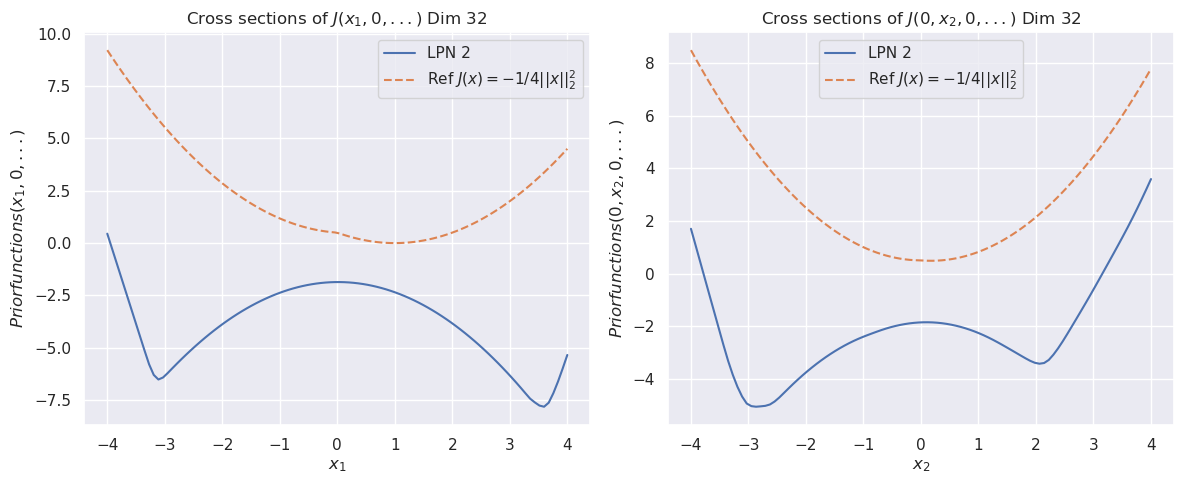

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)